In [1]:

import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Setup Directories
# Tạo cấu trúc thư mục cho character dataset
CHAR_DATASET_DIR = Path('character_dataset')
CHAR_TRAIN_DIR = CHAR_DATASET_DIR / 'train'
CHAR_VAL_DIR = CHAR_DATASET_DIR / 'val'

# Xóa và tạo lại thư mục (nếu muốn bắt đầu từ đầu)
if CHAR_DATASET_DIR.exists():
    response = input(f"⚠️  Directory {CHAR_DATASET_DIR} exists. Remove and recreate? (y/n): ")
    if response.lower() == 'y':
        shutil.rmtree(CHAR_DATASET_DIR)
        print("🗑️  Removed existing directory")

CHAR_DATASET_DIR.mkdir(exist_ok=True)
CHAR_TRAIN_DIR.mkdir(exist_ok=True)
CHAR_VAL_DIR.mkdir(exist_ok=True)

print(f"✅ Directories created:")
print(f"   - {CHAR_TRAIN_DIR}")
print(f"   - {CHAR_VAL_DIR}")

✅ Directories created:
   - character_dataset\train
   - character_dataset\val


In [3]:
# Define Vietnamese License Plate Characters 
# Các ký tự trên biển số xe Việt Nam

# Chữ cái (không có I, O, Q, W)
LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'L', 
           'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z']

# Chữ số
DIGITS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Tất cả các ký tự
ALL_CHARS = sorted(LETTERS + DIGITS)

# Class mapping
CHAR_TO_IDX = {char: idx for idx, char in enumerate(ALL_CHARS)}
IDX_TO_CHAR = {idx: char for char, idx in CHAR_TO_IDX.items()}

NUM_CLASSES = len(ALL_CHARS)

print(f"📋 Character Classes ({NUM_CLASSES} classes):")
print(f"   Letters ({len(LETTERS)}): {LETTERS}")
print(f"   Digits ({len(DIGITS)}): {DIGITS}")
print(f"\n🗂️  Character to Index mapping:")
for i, (char, idx) in enumerate(CHAR_TO_IDX.items()):
    print(f"   {char} -> {idx}", end="    ")
    if (i + 1) % 10 == 0:
        print()

# Tạo thư mục cho mỗi class
for char in ALL_CHARS:
    (CHAR_TRAIN_DIR / char).mkdir(exist_ok=True)
    (CHAR_VAL_DIR / char).mkdir(exist_ok=True)

print(f"\n\n✅ Created {NUM_CLASSES} character folders")

📋 Character Classes (31 classes):
   Letters (21): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z']
   Digits (10): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

🗂️  Character to Index mapping:
   0 -> 0       1 -> 1       2 -> 2       3 -> 3       4 -> 4       5 -> 5       6 -> 6       7 -> 7       8 -> 8       9 -> 9    
   A -> 10       B -> 11       C -> 12       D -> 13       E -> 14       F -> 15       G -> 16       H -> 17       K -> 18       L -> 19    
   M -> 20       N -> 21       P -> 22       R -> 23       S -> 24       T -> 25       U -> 26       V -> 27       X -> 28       Y -> 29    
   Z -> 30    

✅ Created 31 character folders


In [4]:
# Load WPOD Model for License Plate Detection
import torch
from ultralytics import YOLO

# Load model đã train (từ notebook 2)
model_path = Path('F:/pr/runs/detect/license_plate_v12/weights/best.pt')

if not model_path.exists():
    print(f"❌ Model not found at {model_path}")
    print("⚠️  Please train the detection model first (Notebook 2)")
else:
    license_plate_detector = YOLO(str(model_path))
    print(f"✅ License plate detector loaded from: {model_path}")

✅ License plate detector loaded from: F:\pr\runs\detect\license_plate_v12\weights\best.pt


In [5]:
# Character Segmentation Functions 

def preprocess_plate_for_ocr(plate_img):
    """
    Tiền xử lý ảnh biển số để tách ký tự
    """
    # Convert to grayscale
    if len(plate_img.shape) == 3:
        gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    else:
        gray = plate_img.copy()
    
    # Resize to standard height
    h, w = gray.shape
    new_h = 64
    new_w = int(w * new_h / h)
    gray = cv2.resize(gray, (new_w, new_h))
    
    # Convert to HSV for better color separation
    plate_hsv = cv2.cvtColor(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2HSV)
    
    # Apply adaptive threshold on V channel
    v_channel = plate_hsv[:, :, 2]
    binary = cv2.adaptiveThreshold(
        v_channel, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 
        blockSize=21, 
        C=10
    )
    
    # Morphological operations to clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return binary, gray

def segment_characters(binary_img, original_img):
    """
    Tách các ký tự từ ảnh nhị phân
    """
    # Find contours
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter and sort contours
    char_contours = []
    h, w = binary_img.shape
    
    for contour in contours:
        x, y, cw, ch = cv2.boundingRect(contour)
        
        # Filter criteria
        aspect_ratio = cw / ch if ch > 0 else 0
        area = cv2.contourArea(contour)
        bbox_area = cw * ch
        solidity = area / bbox_area if bbox_area > 0 else 0
        
        # Điều kiện lọc
        if (0.15 < aspect_ratio < 1.0 and  # Tỷ lệ khung hình
            ch > h * 0.3 and  # Chiều cao tối thiểu
            ch < h * 0.9 and  # Chiều cao tối đa
            cw > 5 and  # Chiều rộng tối thiểu
            solidity > 0.3):  # Độ đặc
            char_contours.append((x, y, cw, ch, contour))
    
    # Sort by x coordinate (left to right)
    char_contours = sorted(char_contours, key=lambda c: c[0])
    
    # Extract character images
    char_images = []
    for x, y, cw, ch, contour in char_contours:
        # Add padding
        padding = 2
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(w, x + cw + padding)
        y2 = min(h, y + ch + padding)
        
        char_img = original_img[y1:y2, x1:x2]
        
        # Resize to standard size
        char_img = cv2.resize(char_img, (28, 28))
        
        char_images.append({
            'image': char_img,
            'bbox': (x, y, cw, ch)
        })
    
    return char_images

def visualize_segmentation(original_plate, binary, char_images):
    """
    Hiển thị quá trình tách ký tự
    """
    fig, axes = plt.subplots(2, len(char_images) + 2, figsize=(3*(len(char_images)+2), 6))
    
    # Row 1: Original and binary
    axes[0, 0].imshow(cv2.cvtColor(original_plate, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Plate')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(binary, cmap='gray')
    axes[0, 1].set_title('Binary')
    axes[0, 1].axis('off')
    
    # Row 1: Hide extra subplots
    for i in range(2, len(char_images) + 2):
        axes[0, i].axis('off')
    
    # Row 2: Segmented characters
    for i in range(len(char_images) + 2):
        if i < 2:
            axes[1, i].axis('off')
        else:
            if i - 2 < len(char_images):
                axes[1, i].imshow(char_images[i-2]['image'], cmap='gray')
                axes[1, i].set_title(f'Char {i-1}')
                axes[1, i].axis('off')
    
    plt.tight_layout()
    return fig

print("✅ Character segmentation functions defined")

✅ Character segmentation functions defined


In [6]:
# Test Character Segmentation on Sample Images
print("🧪 Testing character segmentation...")

# Get a few sample images
sample_images = list(Path('images/train').glob('*.jpg'))[:5]

for img_path in sample_images:
    print(f"\n📸 Processing: {img_path.name}")
    
    # Detect license plate
    results = license_plate_detector.predict(source=str(img_path), conf=0.25, verbose=False)
    
    if len(results[0].boxes) > 0:
        # Get first detection
        box = results[0].boxes[0]
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        
        # Crop license plate
        img = cv2.imread(str(img_path))
        plate = img[y1:y2, x1:x2]
        
        # Segment characters
        binary, gray = preprocess_plate_for_ocr(plate)
        char_images = segment_characters(binary, gray)
        
        print(f"   ✅ Found {len(char_images)} characters")
        
        # Visualize
        fig = visualize_segmentation(plate, binary, char_images)
        plt.show()
        
        # Only show first image for now
        break
    else:
        print(f"   ❌ No license plate detected")

🧪 Testing character segmentation...


In [7]:
# Manual Labeling Tool
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox

class CharacterLabeler:
    """
    Tool để gán nhãn thủ công cho các ký tự
    """
    def __init__(self, char_images, plate_name):
        self.char_images = char_images
        self.plate_name = plate_name
        self.labels = [''] * len(char_images)
        self.current_idx = 0
        
        self.setup_gui()
    
    def setup_gui(self):
        self.fig = plt.figure(figsize=(15, 8))
        
        # Main image area
        self.ax_main = plt.subplot(2, 2, (1, 2))
        self.ax_main.set_title('Current Character', fontsize=14, fontweight='bold')
        
        # All characters preview
        self.ax_preview = plt.subplot(2, 2, 3)
        self.ax_preview.set_title('All Characters', fontsize=12)
        
        # Instructions
        self.ax_info = plt.subplot(2, 2, 4)
        self.ax_info.axis('off')
        self.update_info()
        
        # Buttons
        ax_prev = plt.axes([0.3, 0.02, 0.1, 0.04])
        ax_next = plt.axes([0.42, 0.02, 0.1, 0.04])
        ax_save = plt.axes([0.54, 0.02, 0.1, 0.04])
        ax_skip = plt.axes([0.66, 0.02, 0.1, 0.04])
        
        self.btn_prev = Button(ax_prev, 'Previous')
        self.btn_next = Button(ax_next, 'Next')
        self.btn_save = Button(ax_save, 'Save All')
        self.btn_skip = Button(ax_skip, 'Skip')
        
        self.btn_prev.on_clicked(self.prev_char)
        self.btn_next.on_clicked(self.next_char)
        self.btn_save.on_clicked(self.save_labels)
        self.btn_skip.on_clicked(self.skip_plate)
        
        # Text input
        ax_text = plt.axes([0.3, 0.08, 0.46, 0.04])
        self.text_box = TextBox(ax_text, 'Label:', initial='')
        self.text_box.on_submit(self.update_label)
        
        self.update_display()
        
    def update_display(self):
        # Show current character
        self.ax_main.clear()
        self.ax_main.imshow(self.char_images[self.current_idx]['image'], cmap='gray')
        self.ax_main.set_title(f"Character {self.current_idx + 1}/{len(self.char_images)}", 
                               fontsize=14, fontweight='bold')
        self.ax_main.axis('off')
        
        # Show all characters with labels
        self.ax_preview.clear()
        preview_img = np.hstack([char['image'] for char in self.char_images])
        self.ax_preview.imshow(preview_img, cmap='gray')
        
        # Add labels
        x_pos = 14
        for i, label in enumerate(self.labels):
            color = 'green' if label else 'red'
            self.ax_preview.text(x_pos, -5, label if label else '?', 
                               ha='center', fontsize=12, fontweight='bold', color=color)
            x_pos += 28
        
        self.ax_preview.axis('off')
        
        self.update_info()
        self.fig.canvas.draw()
    
    def update_info(self):
        self.ax_info.clear()
        self.ax_info.axis('off')
        
        info_text = f"""
        LABELING INSTRUCTIONS:
        
        Plate: {self.plate_name}
        Progress: {sum(1 for l in self.labels if l)}/{len(self.labels)}
        
        1. Type character label in text box
        2. Press ENTER to confirm
        3. Use Next/Previous buttons
        4. Click 'Save All' when done
        5. Click 'Skip' to skip this plate
        
        Valid characters:
        Letters: A-Z (no I,O,Q,W)
        Digits: 0-9
        """
        
        self.ax_info.text(0.1, 0.5, info_text, fontsize=10, 
                         verticalalignment='center', family='monospace')
    
    def update_label(self, text):
        label = text.upper().strip()
        if label in ALL_CHARS:
            self.labels[self.current_idx] = label
            self.text_box.set_val('')
            if self.current_idx < len(self.char_images) - 1:
                self.current_idx += 1
            self.update_display()
        else:
            print(f"❌ Invalid character: {label}")
    
    def next_char(self, event):
        if self.current_idx < len(self.char_images) - 1:
            self.current_idx += 1
            self.update_display()
    
    def prev_char(self, event):
        if self.current_idx > 0:
            self.current_idx -= 1
            self.update_display()
    
    def save_labels(self, event):
        if all(self.labels):
            self.result = self.labels
            plt.close(self.fig)
        else:
            print("⚠️  Please label all characters first!")
    
    def skip_plate(self, event):
        self.result = None
        plt.close(self.fig)
    
    def show(self):
        self.result = []
        plt.show()
        return self.result

print("✅ Manual labeling tool created")

✅ Manual labeling tool created


In [8]:

from tqdm import tqdm
from pathlib import Path
import random

def extract_and_save_characters(image_dir, save_root, split_ratio=0.8):
    image_dir = Path(image_dir)     
    save_root = Path(save_root)      
    
    # Tìm tất cả ảnh
    image_paths = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png")) + list(image_dir.glob("*.jpeg"))
    
    if len(image_paths) == 0:
        print(f"Không tìm thấy ảnh nào trong {image_dir}")
        return
    
    print(f"Đã tìm thấy {len(image_paths)} ảnh trong {image_dir}")
    
    saved_count = 0
    skipped_count = 0
    
    # Tạo thư mục unknown để lưu tạm
    (save_root / "train" / "unknown").mkdir(parents=True, exist_ok=True)
    (save_root / "val" / "unknown").mkdir(parents=True, exist_ok=True)
    
    for img_path in tqdm(image_paths, desc=f"Đang xử lý {image_dir}"):
        img = cv2.imread(str(img_path))
        if img is None:
            continue
            
        # Detect biển số
        results = license_plate_detector.predict(img, conf=0.25, verbose=False, iou=0.45)
        
        if len(results[0].boxes) == 0:
            skipped_count += 1
            continue
            
        # Lấy biển số đầu tiên
        box = results[0].boxes[0]
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        plate = img[y1:y2, x1:x2]
        
        # Tách ký tự
        try:
            binary, gray = preprocess_plate_for_ocr(plate)
            char_images = segment_characters(binary, gray)
        except:
            skipped_count += 1
            continue
        
        if not (6 <= len(char_images) <= 12):  # lọc biển số quá ngắn/dài
            skipped_count += 1
            continue
        
        # Lưu từng ký tự vào thư mục train hoặc val
        for idx, char_info in enumerate(char_images):
            char_img = char_info['image']
            
            # Chia train/val
            if random.random() < split_ratio:
                save_dir = save_root / "train" / "unknown"
            else:
                save_dir = save_root / "val" / "unknown"
            
            filename = f"{img_path.stem}_plate{idx}.jpg"
            cv2.imwrite(str(save_dir / filename), char_img)
            saved_count += 1
    
    print(f"HOÀN TẤT!")
    print(f"   Đã lưu: {saved_count} ký tự")
    print(f"   Bỏ qua: {skipped_count} ảnh (không detect được biển số hoặc lỗi tách ký tự)")
    print(f"   Ký tự đã được lưu vào: {save_root}/train/unknown và val/unknown")
    print(f"   → Giờ bạn vào 2 thư mục này để kéo thả ảnh vào đúng thư mục ký tự (A, B, 5, 9, ...)")
    print(f"   → Hoặc dùng Cell 7 (Manual Labeling Tool) để gán nhãn nhanh hơn!")

# ====================== CHẠY 2 DÒNG NÀY ======================
print("Bắt đầu trích xuất từ tập train...")
extract_and_save_characters("data/images/train", "character_dataset")

print("\nBắt đầu trích xuất từ tập val...")
extract_and_save_characters("data/images/val", "character_dataset")

print("\nXONG! Giờ bạn đã có hàng nghìn ảnh ký tự để gán nhãn!")

Bắt đầu trích xuất từ tập train...
Đã tìm thấy 3433 ảnh trong data\images\train


Đang xử lý data\images\train: 100%|██████████| 3433/3433 [01:29<00:00, 38.51it/s]


HOÀN TẤT!
   Đã lưu: 9594 ký tự
   Bỏ qua: 2128 ảnh (không detect được biển số hoặc lỗi tách ký tự)
   Ký tự đã được lưu vào: character_dataset/train/unknown và val/unknown
   → Giờ bạn vào 2 thư mục này để kéo thả ảnh vào đúng thư mục ký tự (A, B, 5, 9, ...)
   → Hoặc dùng Cell 7 (Manual Labeling Tool) để gán nhãn nhanh hơn!

Bắt đầu trích xuất từ tập val...
Đã tìm thấy 1145 ảnh trong data\images\val


Đang xử lý data\images\val: 100%|██████████| 1145/1145 [00:13<00:00, 84.84it/s] 

HOÀN TẤT!
   Đã lưu: 3187 ký tự
   Bỏ qua: 709 ảnh (không detect được biển số hoặc lỗi tách ký tự)
   Ký tự đã được lưu vào: character_dataset/train/unknown và val/unknown
   → Giờ bạn vào 2 thư mục này để kéo thả ảnh vào đúng thư mục ký tự (A, B, 5, 9, ...)
   → Hoặc dùng Cell 7 (Manual Labeling Tool) để gán nhãn nhanh hơn!

XONG! Giờ bạn đã có hàng nghìn ảnh ký tự để gán nhãn!


In [ ]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# CHỌN THƯ MỤC MUỐN GÁN NHÃN (bạn chọn 1 trong 2)
UNKNOWN_DIR = Path("character_dataset/train/unknown")   # ưu tiên cái này trước (nhiều ảnh hơn)
# UNKNOWN_DIR = Path("character_dataset/val/unknown")     # làm sau

image_paths = sorted(list(UNKNOWN_DIR.glob("*.jpg"))) + \
              sorted(list(UNKNOWN_DIR.glob("*.png"))) + \
              sorted(list(UNKNOWN_DIR.glob("*.jpeg")))

print(f"Đã tìm thấy {len(image_paths)} ảnh cần gán nhãn trong {UNKNOWN_DIR}")

# Tạo sẵn 31 thư mục ký tự nếu chưa có
for char in ALL_CHARS:
    (CHAR_TRAIN_DIR / char).mkdir(exist_ok=True)
    (CHAR_VAL_DIR / char).mkdir(exist_ok=True)

def save_and_next(idx):
    if idx >= len(image_paths):
        print("HOÀN THÀNH GÁN NHÃN!")
        return
    
    img_path = image_paths[idx]
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"{idx+1}/{len(image_paths)} | Nhập ký tự (hoặc 'z' = skip, 'q' = quit):", fontsize=14)
    plt.show()
    
    label = input("Ký tự là gì? ").strip().upper()
    
    if label == 'Q':
        print("Thoát tool.")
        return
    elif label == 'z' or label not in ALL_CHARS:
        print("→ Skip")
    else:
        # Quyết định lưu vào train hay val (giữ nguyên tỷ lệ cũ)
        if "train" in str(UNKNOWN_DIR):
            dest_dir = CHAR_TRAIN_DIR / label
        else:
            dest_dir = CHAR_VAL_DIR / label
        dest_dir.mkdir(exist_ok=True)
        
        new_name = f"{img_path.stem}_{label}.jpg"
        cv2.imwrite(str(dest_dir / new_name), cv2.imread(str(img_path)))
        img_path.unlink()  # xóa khỏi unknown
        print(f"→ Đã lưu vào {dest_dir.name}/{label}")
    
    clear_output(wait=True)
    save_and_next(idx + 1)

# BẮT ĐẦU GÁN NHÃN
save_and_next(0)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Legion\AppData\Roaming\Python\Python313\site-packages\IPython\core\formatters.py", line 282, in catch_format_error
    r = method(self, *args, **kwargs)
  File "C:\Users\Legion\AppData\Roaming\Python\Python313\site-packages\IPython\core\formatters.py", line 402, in __call__
    return printer(obj)
  File "C:\Users\Legion\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py", line 170, in print_figure
    fig.canvas.print_figure(bytes_io, **kw)
    ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^
  File "c:\Users\Legion\miniconda3\Lib\site-packages\matplotlib\backend_bases.py", line 2157, in print_figure
    self.figure.draw(renderer)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^
  File "c:\Users\Legion\miniconda3\Lib\site-packages\matplotlib\artist.py", line 94, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
  File "c:\Users\Legion\miniconda3\Lib\site-packages\matplotlib\artist.py", line 71, in draw_wrapper
    retu

<Figure size 400x400 with 1 Axes>

Thoát tool.


In [9]:
# Dataset Statistics
def analyze_character_dataset():
    """
    Phân tích dataset ký tự đã tạo
    """
    stats = {
        'train': Counter(),
        'val': Counter()
    }
    
    for split in ['train', 'val']:
        split_dir = CHAR_DATASET_DIR / split
        for char_folder in split_dir.iterdir():
            if char_folder.is_dir():
                char = char_folder.name
                count = len(list(char_folder.glob('*.png')))
                stats[split][char] = count
    
    return stats

# Analyze
dataset_stats = analyze_character_dataset()

print("📊 CHARACTER DATASET STATISTICS:")
print("="*70)

for split in ['train', 'val']:
    print(f"\n{split.upper()} SET:")
    total = sum(dataset_stats[split].values())
    print(f"   Total images: {total}")
    
    if total > 0:
        print(f"   Distribution:")
        for char in sorted(ALL_CHARS):
            count = dataset_stats[split].get(char, 0)
            bar = '█' * int(count / max(dataset_stats[split].values()) * 30) if dataset_stats[split] else ''
            print(f"      {char}: {count:4d}  {bar}")

print("="*70)

📊 CHARACTER DATASET STATISTICS:

TRAIN SET:
   Total images: 0

VAL SET:
   Total images: 0


In [10]:
# Visualize Character Dataset 
def visualize_character_samples(num_samples=5):
    """
    Hiển thị mẫu ảnh từ mỗi class
    """
    num_classes = len(ALL_CHARS)
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples*2, num_classes*2))
    
    for class_idx, char in enumerate(ALL_CHARS):
        char_dir = CHAR_TRAIN_DIR / char
        images = list(char_dir.glob('*.png'))[:num_samples]
        
        for sample_idx in range(num_samples):
            ax = axes[class_idx, sample_idx]
            
            if sample_idx < len(images):
                img = cv2.imread(str(images[sample_idx]), cv2.IMREAD_GRAYSCALE)
                ax.imshow(img, cmap='gray')
            
            ax.axis('off')
            
            if sample_idx == 0:
                ax.set_title(f'{char}', fontsize=12, fontweight='bold')
    
    plt.suptitle('Character Dataset Samples', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('character_dataset_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualization saved as 'character_dataset_samples.png'")

# Visualize
if sum(dataset_stats['train'].values()) > 0:
    visualize_character_samples(num_samples=5)
else:
    print("⚠️  No training data available yet. Please label more images first.")

⚠️  No training data available yet. Please label more images first.


In [11]:
# Build Character Recognition Model 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

class CharacterCNN(nn.Module):
    """
    CNN Model cho nhận diện ký tự biển số
    """
    def __init__(self, num_classes=31):
        super(CharacterCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout

In [12]:
# Create Dataset and DataLoader
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class CharacterDataset(Dataset):
    """
    Custom Dataset cho character recognition
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []
        self.class_to_idx = CHAR_TO_IDX
        
        # Load all images
        for char in ALL_CHARS:
            char_dir = self.root_dir / char
            if char_dir.exists():
                for img_path in char_dir.glob('*.png'):
                    self.samples.append((str(img_path), self.class_to_idx[char]))
        
        print(f"📂 Loaded {len(self.samples)} samples from {root_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Load image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_class_distribution(self):
        """Trả về phân phối các class"""
        distribution = Counter([label for _, label in self.samples])
        return distribution

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets
train_dataset = CharacterDataset(CHAR_TRAIN_DIR, transform=train_transform)
val_dataset = CharacterDataset(CHAR_VAL_DIR, transform=val_transform)

print(f"\n📊 Dataset Statistics:")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")

if len(train_dataset) > 0:
    train_dist = train_dataset.get_class_distribution()
    print(f"\n   Training distribution:")
    for char_idx, count in sorted(train_dist.items()):
        char = IDX_TO_CHAR[char_idx]
        print(f"      {char}: {count}")

📂 Loaded 0 samples from character_dataset\train
📂 Loaded 0 samples from character_dataset\val

📊 Dataset Statistics:
   Training samples: 0
   Validation samples: 0


In [27]:
# Create DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"✅ DataLoaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

# Visualize a batch
if len(train_loader) > 0:
    images, labels = next(iter(train_loader))
    print(f"\n📦 Batch shape:")
    print(f"   Images: {images.shape}")
    print(f"   Labels: {labels.shape}")
    
    # Visualize
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx in range(min(32, len(images))):
        img = images[idx].squeeze().numpy()
        label = labels[idx].item()
        char = IDX_TO_CHAR[label]
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f'{char}', fontsize=12)
        axes[idx].axis('off')
    
    plt.suptitle('Sample Training Batch', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [14]:
# Training Configuration
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🎯 Using device: {device}")

# Model
model = CharacterCNN(num_classes=NUM_CLASSES).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training parameters
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 10

print(f"\n⚙️ Training Configuration:")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"   Optimizer: Adam")
print(f"   Loss function: CrossEntropyLoss")
print(f"   Early stopping patience: {EARLY_STOP_PATIENCE}")

🎯 Using device: cuda


AttributeError: 'CharacterCNN' object has no attribute 'dropout'

In [15]:
# Training Functions 
from tqdm import tqdm

def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train một epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{running_loss/len(pbar):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """
    Validate model
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{running_loss/len(pbar):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

print("✅ Training functions defined")

✅ Training functions defined


In [16]:
# Train Model 
import time

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'character_recognition_best.pth'

print("\n" + "="*70)
print("🚀 STARTING TRAINING")
print("="*70)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\n📅 Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    # Print results
    print(f"\n📊 Results:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"   Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'char_to_idx': CHAR_TO_IDX,
            'idx_to_char': IDX_TO_CHAR
        }, best_model_path)
        print(f"   💾 Saved best model (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"   ⏳ Patience: {patience_counter}/{EARLY_STOP_PATIENCE}")
    
    # Early stopping
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"\n⚠️  Early stopping triggered after {epoch+1} epochs")
        break

training_time = time.time() - start_time
print("\n" + "="*70)
print(f"✅ TRAINING COMPLETED")
print(f"⏱️  Total time: {training_time/60:.2f} minutes")
print(f"💾 Best model saved to: {best_model_path}")
print("="*70)


🚀 STARTING TRAINING


NameError: name 'NUM_EPOCHS' is not defined

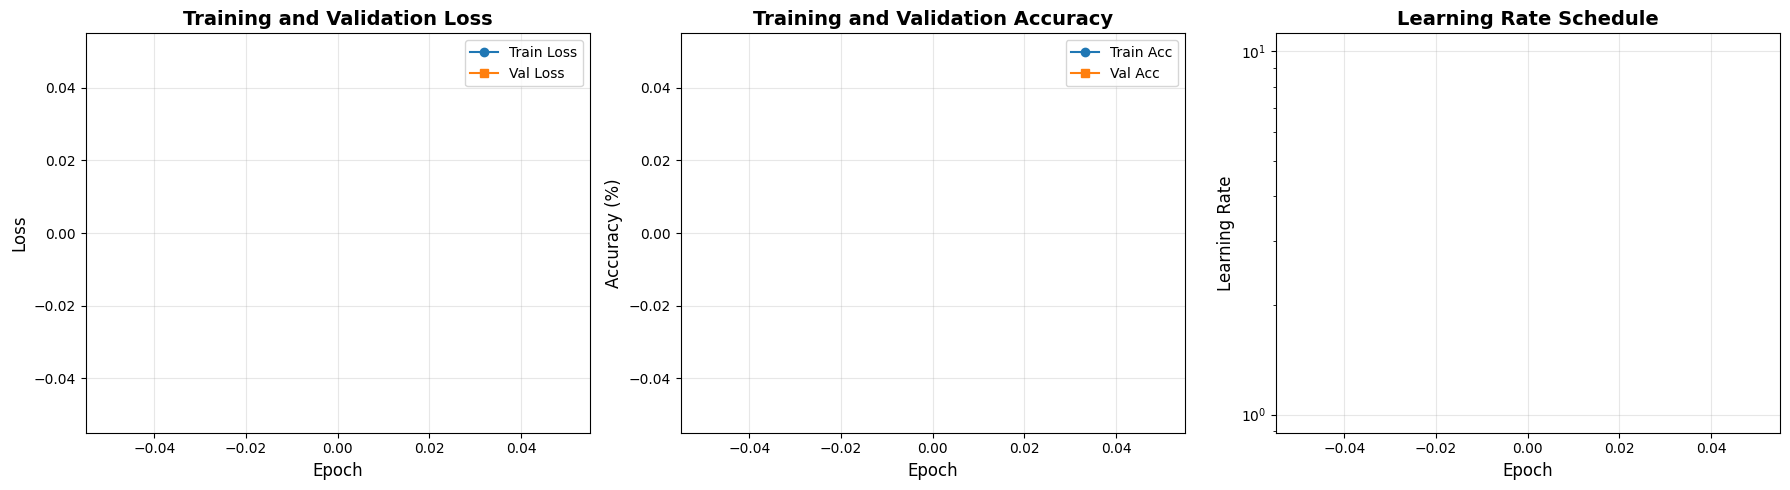

✅ Training history saved as 'training_history.png'


In [17]:
# Plot Training History 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(history['lr'], marker='o', color='red')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training history saved as 'training_history.png'")

In [ ]:
# Load Best Model and Evaluate 
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"   Val Loss: {checkpoint['val_loss']:.4f}")
print(f"   Val Acc: {checkpoint['val_acc']:.2f}%")

# Evaluate on validation set
val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)

print(f"\n📊 Final Validation Results:")
print(f"   Loss: {val_loss:.4f}")
print(f"   Accuracy: {val_acc:.2f}%")

FileNotFoundError: [Errno 2] No such file or directory: 'character_recognition_best.pth'

In [ ]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Normalize
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=ALL_CHARS, yticklabels=ALL_CHARS,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=ALL_CHARS, yticklabels=ALL_CHARS,
            ax=axes[1], cbar_kws={'label': 'Proportion'})
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved as 'confusion_matrix.png'")

NameError: name 'val_labels' is not defined

In [ ]:
# Classification Report
# Generate classification report
report = classification_report(
    val_labels, 
    val_preds, 
    target_names=ALL_CHARS,
    digits=4
)

print("\n📋 CLASSIFICATION REPORT:")
print("="*70)
print(report)

# Save to file
with open('classification_report.txt', 'w') as f:
    f.write(report)

print("\n✅ Classification report saved as 'classification_report.txt'")

NameError: name 'val_labels' is not defined

In [ ]:
# Analyze Difficult Cases 
# Find misclassified examples
misclassified_indices = [i for i, (pred, label) in enumerate(zip(val_preds, val_labels)) if pred != label]

print(f"🔍 Found {len(misclassified_indices)} misclassified samples ({len(misclassified_indices)/len(val_labels)*100:.2f}%)")

if len(misclassified_indices) > 0:
    # Show some examples
    num_examples = min(16, len(misclassified_indices))
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    for idx, mis_idx in enumerate(misclassified_indices[:num_examples]):
        img_path, true_label = val_dataset.samples[mis_idx]
        pred_label = val_preds[mis_idx]
        
        # Load and display image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f'True: {IDX_TO_CHAR[true_label]}\nPred: {IDX_TO_CHAR[pred_label]}',
                           fontsize=10, color='red')
        axes[idx].axis('off')
    
    plt.suptitle('Misclassified Examples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('misclassified_examples.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Misclassified examples saved as 'misclassified_examples.png'")
    
    # Analyze common confusions
    print("\n🔍 Most Common Confusions:")
    confusion_pairs = Counter()
    for mis_idx in misclassified_indices:
        _, true_label = val_dataset.samples[mis_idx]
        pred_label = val_preds[mis_idx]
        pair = (IDX_TO_CHAR[true_label], IDX_TO_CHAR[pred_label])
        confusion_pairs[pair] += 1
    
    for (true_char, pred_char), count in confusion_pairs.most_common(10):
        print(f"   {true_char} → {pred_char}: {count} times")

NameError: name 'val_preds' is not defined